### Working With Imbalanced Data and Classifier Evaluation

In today's lab, we're going to work through a sample classification problem that will allow us to see how to improve and evaluate a classifier where there's imbalanced data.  

The point is to get used to using a confusion matrix, and using metrics like `precision`, `recall` and the `f1_score` in order to think about how well our model is performing across different labels.

In [80]:
# imports
import pandas as pd
import numpy as np
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
# suppress warning messages
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score

In [81]:
def get_model_scores(mod, X_train, y_train, X_test, y_test, val_score = True, test_score=False):
    if val_score:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                          test_size = 0.2, 
                                                          stratify = y_train, 
                                                          random_state= 42)
 
    mod.fit(X_train, y_train)
    
    results = {}
    #f1_score(mod.predict(X_val), y_val)
    results['train_score'] = mod.score(X_train, y_train)
    if val_score:
        results['val_score'] = mod.score(X_val, y_val)
        
    if test_score:
        results['test_score'] = mod.score(X_test, y_test)
        
    return results

**Step 1:** Load in the `pima` dataset, and do the following:

 - Create training, validation and test sets
 - Fit a `GradientBoostingClassifier` with the default configuration on your training set
 - Get both model accuracy and the `f1_score` on the validation set

In [82]:
df = pd.read_csv(r"/Users/ethanalter/Dropbox (Personal)/GA-4K-DataScience/gazelle-4K/unit3_data/pima.csv")

In [83]:
df

,NumChildren,GlucoseConcentration,Diastolic,BodyFatTest,SerumInsulin,BMI,DiabeticScore,Age,Diabetic
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [84]:
# def split_data(df, split_frac=0.2, random_state=42):
#     X  = df.drop('Diabetic', axis=1)
#     y  = df['Diabetic']
#     # notice the use of 'stratify' -- makes sure y values are in equal proportions in train + test
#     return train_test_split(X, y, test_size = split_frac, stratify = y, random_state = random_state)

In [85]:
df['Diabetic'].mean()

0.3489583333333333

In [86]:
weighting = (1/df['Diabetic'].mean())

In [87]:
weighting

2.865671641791045

In [88]:
#create test and training 
X_train, X_test, y_train, y_test = train_test_split(df.drop('Diabetic', axis = 1), df['Diabetic'], 
                                                    stratify = df['Diabetic'],
                                                    test_size = 0.2)

In [89]:
#create validation 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    stratify = y_train,
                                                    test_size = 0.2)

In [90]:
#instantiate model 
model = XGBClassifier(eval_metric = 'logloss')

In [91]:
#no need to create pipeline here as we're not encoding anything! 
#straight to fitting the mod

model.fit(X_train, y_train).score(X_val, y_val)


0.7560975609756098

In [92]:
f1_score(model.predict(X_val), y_val)

0.6341463414634145

Note that we're **fitting on the training set** and then **scoring on the validation set**

**Step 2:** Look at both the confusion matrix and classification report on your validation set.  Make sure you can recall what each metric means.

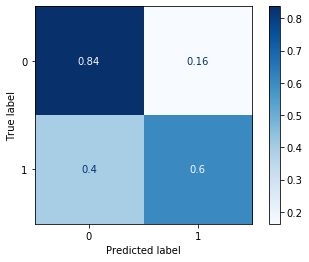

In [93]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

plot_confusion_matrix(model, X_val, y_val,
                                 cmap=plt.cm.Blues,
                                 normalize='true');

In [94]:
print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        80
           1       0.67      0.60      0.63        43

    accuracy                           0.76       123
   macro avg       0.73      0.72      0.73       123
weighted avg       0.75      0.76      0.75       123



**Step 3:** Do a parameter search using the following four categories:
 - `n_estimators`
 - `max_depth`
 - `subsample`
 - `scale_pos_weight`
 
 When you are done, refit your model on the training data using the best combination, and look at your new classification report and confusion matrix to see how they changed

In [106]:
estimators = [50, 100, 150]
max_depth  = [3, 4]
sub_sample = [1.0, 0.8, 0.6] # this is the amount of samples to randomly sample in each round
scale_pos_weight  = [2, 2.86, 3.5]
cv_scores = []

# do a training loop
for estimator in estimators:
    for depth in max_depth:
        for sample in sub_sample:
            for weight in scale_pos_weight:
                print(f"Fitting new training loop for rounds: {estimator}, depth: {depth}, sampling rate: {sample}, pos_weight: {weight}")
                model.set_params(n_estimators = estimator, max_depth = depth, subsample = sample, scale_pos_weight = weight)
                model.fit(X_train, y_train) #always fit on training! 
                score = f1_score(model.predict(X_val), y_val)
                cv_scores.append((score, estimator, depth, sample, weight))

Fitting new training loop for rounds: 50, depth: 3, sampling rate: 1.0, pos_weight: 2
Fitting new training loop for rounds: 50, depth: 3, sampling rate: 1.0, pos_weight: 2.86
Fitting new training loop for rounds: 50, depth: 3, sampling rate: 1.0, pos_weight: 3.5
Fitting new training loop for rounds: 50, depth: 3, sampling rate: 0.8, pos_weight: 2
Fitting new training loop for rounds: 50, depth: 3, sampling rate: 0.8, pos_weight: 2.86
Fitting new training loop for rounds: 50, depth: 3, sampling rate: 0.8, pos_weight: 3.5
Fitting new training loop for rounds: 50, depth: 3, sampling rate: 0.6, pos_weight: 2
Fitting new training loop for rounds: 50, depth: 3, sampling rate: 0.6, pos_weight: 2.86
Fitting new training loop for rounds: 50, depth: 3, sampling rate: 0.6, pos_weight: 3.5
Fitting new training loop for rounds: 50, depth: 4, sampling rate: 1.0, pos_weight: 2
Fitting new training loop for rounds: 50, depth: 4, sampling rate: 1.0, pos_weight: 2.86
Fitting new training loop for rounds

In [107]:
cv_scores

[(0.7252747252747254, 50, 3, 1.0, 2),
 (0.7083333333333334, 50, 3, 1.0, 2.86),
 (0.6947368421052632, 50, 3, 1.0, 3.5),
 (0.6888888888888888, 50, 3, 0.8, 2),
 (0.7157894736842104, 50, 3, 0.8, 2.86),
 (0.673469387755102, 50, 3, 0.8, 3.5),
 (0.6436781609195402, 50, 3, 0.6, 2),
 (0.6464646464646464, 50, 3, 0.6, 2.86),
 (0.693877551020408, 50, 3, 0.6, 3.5),
 (0.7126436781609196, 50, 4, 1.0, 2),
 (0.6593406593406593, 50, 4, 1.0, 2.86),
 (0.6526315789473683, 50, 4, 1.0, 3.5),
 (0.651685393258427, 50, 4, 0.8, 2),
 (0.6976744186046512, 50, 4, 0.8, 2.86),
 (0.6888888888888888, 50, 4, 0.8, 3.5),
 (0.6966292134831461, 50, 4, 0.6, 2),
 (0.6739130434782609, 50, 4, 0.6, 2.86),
 (0.6666666666666666, 50, 4, 0.6, 3.5),
 (0.674698795180723, 100, 3, 1.0, 2),
 (0.7045454545454545, 100, 3, 1.0, 2.86),
 (0.6666666666666666, 100, 3, 1.0, 3.5),
 (0.7294117647058824, 100, 3, 0.8, 2),
 (0.6966292134831461, 100, 3, 0.8, 2.86),
 (0.6666666666666666, 100, 3, 0.8, 3.5),
 (0.6904761904761904, 100, 3, 0.6, 2),
 (0.615

**Step 4:** Refit your model on all of your training data and get your test score.

In [97]:
# your code here